### v5:

   * Add RC feature (with spring above at .5): 1.0432, .780
   * Add R/C feature (with eqn above at .5): 1.027, .7752
   * Add C/R feature also (with eqn above at .5):  1.0276, .7743
   * added breath_id back: 1.0316, .77345
   * with second deriv = 1.013, .741  some improvement!  But why doesn't the corr reflect this?
   * catboost 10000 iterations: .677 !!! It is starting to increase better at higher iterations
   * 20000 iterations: .637 approaching the RF score (.61)
   * 30000 iterations! depth=6, .5887!!  But leaderboard was .70!  
       * **I guess that means overfitting!
   * with 3rd deriv and u_in_squared added: 1.0117, .7363, try rf: .50277 vs. .5846 lb...best so far
     * baselining for v5

### Previous Versions

Adding max u_in feature helped score from  ~.75 to ~.65.

Pipeline is:
* reduce memory
* split into two sets
* add features: max_time, max_u_in, dt, u_in_slope, u_in_area

Fork v1 adds u_in_ratio feature
* catboost drops a little 1.09 to ~1.065 ,didnt run rf.

Add 1/area feature since R decreases with increasing lung volume
   * helps a little, not much
   * with 1/R*area: 1.0727, .808181 
 
v4?
Add R(1-np.exp(-1*t/t_max)
   * spring R(1-np.exp(-1*time/time_max)): 1.0661, .7899
   * spring R(1-np.exp(-2*time/time_max)): 1.0612, .7857
   * spring R(1-np.exp(-3*time/time_max)): 1.0551, .7868
   * spring R(1-np.exp(-5*time/time_max)): 1.0575, .7847
   * spring R(1-np.exp(-R*time/time_max)): 1.0529, .7877
   * spring R(1-np.exp(-.5*R*time/time_max)): 1.0541, .7842
   * spring R(1-np.exp(-.2*R*time/time_max)): 1.0549, .7854


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import platform
pd.options.mode.chained_assignment = None

# Functions

In [2]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

In [3]:
def plot_breath(df,my_id):
    id1 = get_breath(df,my_id)
    r = id1.R.iloc[0]
    c = id1.C.iloc[0]
    plt.figure(figsize=(8,5))
    plt.plot(id1.pressure,label='pressure')
    plt.plot(id1.u_in,label='u_in')
    plt.title(f'Pressure and u_in for Breath id={my_id}, R={r}, C={c}')
    plt.legend();

# Load Files

In [4]:
%%time
# Load files
if platform.system() == 'Windows' and platform.release() == '7':
    drive = 'F'
elif platform.system() == 'Windows' and platform.release() == '10':
    drive = 'C'
    
train = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')
    
#train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
#test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

y = train['pressure']


Wall time: 15.7 s


# Memory Reduction

In [5]:
# down convert columns to save memory...
def reduce_memory(df):
    
    print(f'Initial memory usage: {df.memory_usage().sum()/1024**2:0.1f}GB')
    df['id'] = df['id'].astype(np.int32)
    df['breath_id'] = df['breath_id'].astype(np.int32)
    df['R'] = df['R'].astype(np.int8)  #or OHC?
    df['C'] = df['C'].astype(np.int8)
    df['u_out'] = df['u_out'].astype(np.int8)
    df['u_in'] = df['u_in'].astype(np.float32)
    df['time_step'] = df['time_step'].astype(np.float32)
    print(f'New memory usage: {df.memory_usage().sum()/1024**2:0.1f}GB')
    
    # somewhere else I printed out a reduction as well.
    
#     for col in test.columns:
#         print(test[col].dtype)

In [6]:
print('Train:')
reduce_memory(train)
print('Test:')
reduce_memory(test)


Train:
Initial memory usage: 368.4GB
New memory usage: 155.4GB
Test:
Initial memory usage: 214.9GB
New memory usage: 72.9GB


# Split data into inhalitory and exhalitory phase (only scored on inhale)

In [7]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

#  Add Features

    1. Apply lag shift (tested shift =1 ) 
        Shift = 2 performs better (2.37 vs. 2.0x)
    2. Add differentials for dt and du_in
    3. Add integral column for d_uin



In [8]:
# first add max_u_in value before lag shift
train_in["max_u_in"] = train_in.groupby("breath_id")["u_in"].transform("max")
test_in["max_u_in"] = test_in.groupby("breath_id")["u_in"].transform("max")

train_in["u_in_ratio"] = train_in.u_in/train_in.max_u_in
test_in["u_in_ratio"] = test_in.u_in/test_in.max_u_in
train_in["u_in_ratio"] = train_in.u_in_ratio.fillna(0)
test_in["u_in_ratio"] = test_in.u_in_ratio.fillna(0)


In [9]:
train_in
#train_in.inv_area.isinf().sum()
np.isinf(train_in).values.sum()

0

### Apply lag shift

In [10]:
shift = 1
# apply lag shift in training set
u_in_lag = train_in.u_in.shift(shift,fill_value=0)
train_in.loc[:,'u_in_lag'] = u_in_lag.copy()
train_in.drop(['u_in'],axis=1,inplace=True)

# and for test set
u_in_lag = test_in.u_in.shift(shift,fill_value=0)
test_in.loc[:,'u_in_lag'] = u_in_lag.copy()
test_in.drop(['u_in'],axis=1,inplace=True)

In [11]:
# transition 1
train_in[0:33]

,id,breath_id,R,C,time_step,u_out,pressure,max_u_in,u_in_ratio,u_in_lag
0,1,1,20,50,0.000000,0,5.837492,28.313036,0.002943,0.000000
1,2,1,20,50,0.033652,0,5.907794,28.313036,0.649278,0.083334
2,3,1,20,50,0.067514,0,7.876254,28.313036,0.795015,18.383041
3,4,1,20,50,0.101542,0,11.742872,28.313036,0.805594,22.509277
4,5,1,20,50,0.135756,0,12.234987,28.313036,0.895554,22.808823
5,6,1,20,50,0.169698,0,12.867706,28.313036,0.962803,25.355850
6,7,1,20,50,0.203708,0,14.695562,28.313036,0.958127,27.259867
7,8,1,20,50,0.237723,0,15.890699,28.313036,0.946834,27.127485
8,9,1,20,50,0.271776,0,15.539188,28.313036,0.984166,26.807732
9,10,1,20,50,0.305732,0,15.750094,28.313036,1.000000,27.864716


In [12]:
# u_in leaking into next breath...number leaked = 
transitions = np.where(np.diff(train_in.breath_id) == 1)
transitions[0]
# for r in transitions[0]:
#     print(train_in.u_in_lag.iloc[r+1])

array([     29,      58,      90, ..., 2290785, 2290817, 2290876],
      dtype=int64)

In [13]:
# make an index of breaths
train_breath_idx = train_in.breath_id.unique()
test_breath_idx = test_in.breath_id.unique()
test_breath_idx

array([     0,      8,     11, ..., 125746, 125747, 125748])

### Add Differential, Integral, and other Features

In [14]:
# faster area calculation... need to compeletely verify behaviour
# time delta is identical to my dt
# area is idential to u_in_integ, but one step behind (can use to check things.)

train_in['dt'] = train_in['time_step'].diff()
train_in['dt'].fillna(0, inplace=True)  # no na values so not needed
train_in['dt'].mask(train_in['dt'] < 0,0,inplace=True) #train_in.groupby('breath_id')['dt'].mean(), inplace=True)  #makes 

train_in['d_area'] = train_in['dt'] * train_in['u_in_lag']
train_in['u_in_area'] = train_in.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
train_in['inv_area'] = 1/(train_in.R*train_in['u_in_area'])
train_in.replace([np.inf, -np.inf], np.nan, inplace=True)
train_in['inv_area'].fillna(0, inplace=True)
train_in['u_in_sq'] = train_in.u_in_lag * train_in.u_in_lag
    
train_in['du_in'] = train_in['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
train_in['du_in'].mask(train_in['dt'] == 0, 0, inplace=True)
train_in['dt'].fillna(0, inplace=True)
train_in['du2_in'] = train_in['du_in'].diff()
train_in['du2_in'].mask(train_in['dt'] == 0, 0, inplace=True)
train_in['du3_in'] = train_in['du2_in'].diff()
train_in['du3_in'].mask(train_in['dt'] == 0, 0, inplace=True)


train_in["max_time"] = train_in.groupby("breath_id")["time_step"].transform("max")
train_in['R_spring'] = train_in.R*(1-np.exp((-.5*train_in.R*train_in.time_step)/train_in.max_time))

train_in['RC'] = train_in.R * train_in.C
train_in['RoverC'] = train_in.R/train_in.C
train_in['CoverR'] = train_in.C/train_in.R


# same feature additions with test
test_in['dt'] = test_in['time_step'].diff()
test_in['dt'].fillna(0, inplace=True)  # no na values so not needed
test_in['dt'].mask(test_in['dt'] < 0, 0, inplace=True)

test_in['d_area'] = test_in['dt'] * test_in['u_in_lag']
test_in['u_in_area'] = test_in.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
test_in['inv_area'] = 1/(test_in.R*test_in['u_in_area'])
test_in.replace([np.inf, -np.inf], np.nan, inplace=True)
test_in['inv_area'].fillna(0, inplace=True)
test_in['u_in_sq'] = test_in.u_in_lag * test_in.u_in_lag
    
test_in['du_in'] = test_in['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
test_in['du_in'].mask(test_in['dt'] == 0, 0, inplace=True)
test_in['du2_in'] = test_in['du_in'].diff()
test_in['du2_in'].mask(test_in['dt'] == 0, 0, inplace=True)
test_in['du3_in'] = test_in['du2_in'].diff()
test_in['du3_in'].mask(test_in['dt'] == 0, 0, inplace=True)


test_in["max_time"] = test_in.groupby("breath_id")["time_step"].transform("max")
test_in['R_spring'] = test_in.R*(1-np.exp((-.5*test_in.R*test_in.time_step)/test_in.max_time))

test_in['RC'] = test_in.R * test_in.C
test_in['RoverC'] = test_in.R/test_in.C
test_in['CoverR'] = test_in.C/test_in.R

# Drop unused axes
train_in.drop(['d_area'],axis=1,inplace=True)
test_in.drop(['d_area'],axis=1,inplace=True)

Visualize features

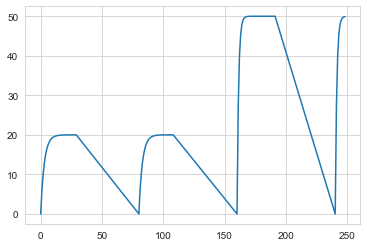

In [15]:

plt.plot(train_in.R_spring[0:100])


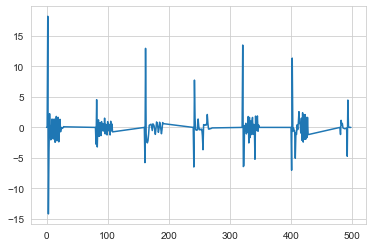

In [16]:
plt.plot(train_in.du2_in[0:200])

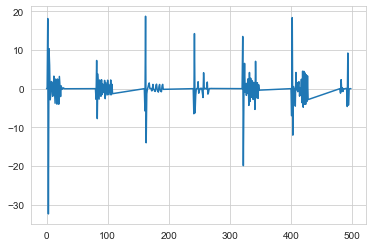

In [17]:
plt.plot(train_in.du3_in[0:200])

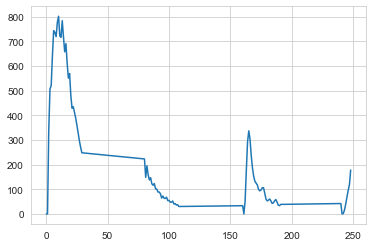

In [18]:
plt.plot(train_in.u_in_sq[0:100])

In [19]:
train_in.head(33)

,id,breath_id,R,C,time_step,u_out,pressure,max_u_in,u_in_ratio,u_in_lag,...,inv_area,u_in_sq,du_in,du2_in,du3_in,max_time,R_spring,RC,RoverC,CoverR
0,1,1,20,50,0.000000,0,5.837492,28.313036,0.002943,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.987487,0.000000,-24,0.4,2.5
1,2,1,20,50,0.033652,0,5.907794,28.313036,0.649278,0.083334,...,17.829243,0.006945,0.083334,0.083334,0.083334,0.987487,5.775797,-24,0.4,2.5
2,3,1,20,50,0.067514,0,7.876254,28.313036,0.795015,18.383041,...,0.079963,337.936218,18.299707,18.216373,18.133039,0.987487,9.905073,-24,0.4,2.5
3,4,1,20,50,0.101542,0,11.742872,28.313036,0.805594,22.509277,...,0.035939,506.667572,4.126236,-14.173471,-32.389847,0.987487,12.847635,-24,0.4,2.5
4,5,1,20,50,0.135756,0,12.234987,28.313036,0.895554,22.808823,...,0.023025,520.242371,0.299545,-3.826691,10.346781,0.987487,14.941982,-24,0.4,2.5
5,6,1,20,50,0.169698,0,12.867706,28.313036,0.962803,25.355850,...,0.016489,642.919128,2.547028,2.247482,6.074173,0.987487,16.413232,-24,0.4,2.5
6,7,1,20,50,0.203708,0,14.695562,28.313036,0.958127,27.259867,...,0.012628,743.100342,1.904016,-0.643011,-2.890493,0.987487,17.458282,-24,0.4,2.5
7,8,1,20,50,0.237723,0,15.890699,28.313036,0.946834,27.127485,...,0.010242,735.900452,-0.132381,-2.036398,-1.393387,0.987487,18.198926,-24,0.4,2.5
8,9,1,20,50,0.271776,0,15.539188,28.313036,0.984166,26.807732,...,0.008628,718.654480,-0.319754,-0.187372,1.849026,0.987487,18.724256,-24,0.4,2.5
9,10,1,20,50,0.305732,0,15.750094,28.313036,1.000000,27.864716,...,0.007417,776.442383,1.056984,1.376738,1.564110,0.987487,19.095458,-24,0.4,2.5


In [20]:
# save prepared train_in and test_in
train_in.shape


(2290968, 22)

<AxesSubplot:>

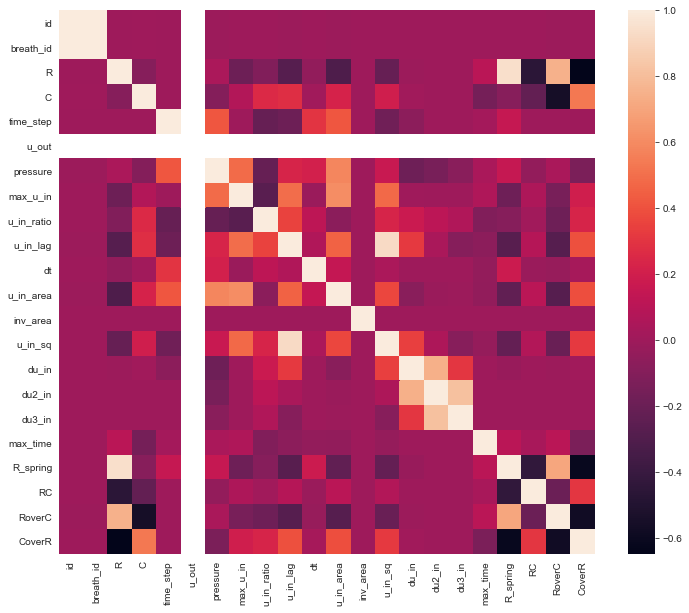

In [21]:
plt.figure(figsize=(12,10))
sns.heatmap(train_in.corr())

# Model

In [22]:
from sklearn.metrics import mean_absolute_error  #confusion_matrix, classification_report

## Need to ditch split and go to cross validation

In [23]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

test_drop_cols = ['id','breath_id','u_out','dt']
train_drop_cols = test_drop_cols.copy()
train_drop_cols.append('pressure')

train_in.drop(columns = ['id','u_out','pressure'], inplace = True)
#test = test.drop(columns = 'id', inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)
X_test_in = test_in.drop(columns=['id','u_out'],inplace=False)

In [24]:
test_in.head()

,id,breath_id,R,C,time_step,u_out,max_u_in,u_in_ratio,u_in_lag,dt,...,inv_area,u_in_sq,du_in,du2_in,du3_in,max_time,R_spring,RC,RoverC,CoverR
0,1,0,5,20,0.000000,0,37.542217,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.957189,0.000000,100,0.25,4.0
1,2,0,5,20,0.031904,0,37.542217,0.200176,0.000000,0.031904,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.957189,0.399747,100,0.25,4.0
2,3,0,5,20,0.063827,0,37.542217,0.390272,7.515046,0.031924,...,0.833657,56.475910,7.515046,7.515046,7.515046,0.957189,0.767754,100,0.25,4.0
3,4,0,5,20,0.095751,0,37.542217,0.565513,14.651675,0.031924,...,0.282628,214.671585,7.136630,-0.378416,-7.893462,0.957189,1.106323,100,0.25,4.0
4,5,0,5,20,0.127644,0,37.542217,0.701103,21.230610,0.031893,...,0.144431,450.738800,6.578935,-0.557695,-0.179279,0.957189,1.417515,100,0.25,4.0


In [25]:
%%time
from catboost import CatBoostRegressor
# loop for manual type cv
#preds = []
for i in [400,4000]:
#     X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2,
#                                                       random_state=i)
    model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               task_type="GPU",
                               learning_rate=.6,
                               iterations=i,
                               l2_leaf_reg=50,
                               random_seed=12,
                               #od_type="Iter",
                               depth=5,
                               #early_stopping_rounds=6500,
                               #border_count=64,
                               verbose=False
                              )
    model_cat.fit(X_train,y_train)
    pred_cat = model_cat.predict(X_valid)
    score_cat = mean_absolute_error(y_valid,pred_cat)
    #print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
    print(f'CatBoost MAE Score: {score_cat}')
    #preds.append(model_cat.predict_proba(X_test)[:,1])
    # 400, .6 = 3.976 
    # with deriv, integral
    # 400, .6 = 1.42
    # 4000,.6 = 1.21 (1.18 lb)
    # 8000,.6 = 1.12 (1.14 lb) maybe starting to overfit
    # shift = 1 (still need to review lining up)
    # 400, .6 = 1.22
    # 4000: 1.1277 
    # try shift = 2, = 1.23 with 4000,.6 (worse)
    
    # again...
    # shift 1 = 1.287 with 400, .6 (1.33 with older method..shifting integral better?)
    # shift 1 = 1.0773 with 4000, .6, so it is a little better than the 1.1227 with the older method
    # removed NaN from dt, integ and is a little worse. 1.079 ()
    # 1.1943 with max_time added and 400 iters, rt = .65!
    # adding d_area column, 400,.6 mae = 1.1987 (slightly higher)
    # 4000 = .9679  what was it previosly?  Forgot to run (or record).
    # Next, study of l2_leaf_reg 5-45 in 5 inc: virtually no change: 1.1947-1.195x
    # Removed some other parameters. 400, .77 = 1.653, 4000, .77 = .943
    # 4000, .057: .9404
    # try some more lr values at 4000 iters .2 to .8 in .01 increments.  Not much improvement compared to rf: .985-.935
    # Best prev: 16000, .71,45,20 = .86958   ...still not competitive with random forest


    # 400, .6,50,5 = 1.09! , 4000 = .833!  this is lower..._adding max_u_in helped!
    
    # add u_in ratio...if I fill na with zeros, 400, 4000:
    # CatBoost MAE Score: 1.1315940327192697, 0.8594030798739087
    # if I don't fill na in u_in_ratios:
    # CatBoost MAE Score: 1.125316246725629, 0.8638797903427912
    # add dt col back
    # CatBoost MAE Score: 1.0696357140212032, 0.8173306530838652
    # remove nans again...acutally a little better
    # CatBoost MAE Score: 1.0640880797871226, 0.8171753258386951
    # with just 1/area: 1.08, .823
    # with R/area: 1.0753, .808912
    # with 1/R*area: 1.0727, .808181  ...nearly the same but marginally lower at 4000, check rf
    # again...1.08737, .0804.  Since this is the lowest so far, I am going to run rf.  Maybe try 8k catboost runs
    # spring R(1-np.exp(-1*time/time_max)): 1.0661, .7899
    # spring R(1-np.exp(-2*time/time_max)): 1.0612, .7857
    # spring R(1-np.exp(-3*time/time_max)): 1.0551, .7868
    # spring R(1-np.exp(-5*time/time_max)): 1.0575, .7847
    # spring R(1-np.exp(-R*time/time_max)): 1.0529, .7877
    # spring R(1-np.exp(-.5*R*time/time_max)): 1.0541, .7842
    # spring R(1-np.exp(-.2*R*time/time_max)): 1.0549, .7854
    # Add RC feature (with spring above at .5): 1.0432, .780
    # Add R/C feature (with eqn above at .5): 1.027, .7752
    # Add C/R feature also (with eqn above at .5):  1.0276, .7743
    # added breath_id back: 1.0316, .77345
    # with second deriv = 1.013, .741  some improvement!  But why doesn't the corr reflect this?
    
    # catboost 10000 iterations: .677 !!! It is starting to increase better at higher iterations
    # 20000 iterations: .637 approaching the RF score (.61)
    # 30000 iterations! depth=6, .5887!!  But leaderboard was .70!  I guess that means overfitting!

    # with 3rd deriv and u_in**2 added: 1.0117, .7363, try rf: .50277 vs. .5846 lb...best so far
    

CatBoost MAE Score: 1.01170194718277
CatBoost MAE Score: 0.7366422193128561
Wall time: 2min 6s


In [277]:
# grid search
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

#instantiate the model
model_cbcv = CatBoostRegressor(verbose=False, task_type='GPU')
#create the grid
grid = {'max_depth': [4,5,6],'n_estimators':[10000, 20000, 30000]}
# instantiate gridsearchcv
gscv = GridSearchCV (estimator = model_cbcv, param_grid = grid, scoring ="neg_mean_absolute_error", cv = 5)
gscv.fit(train_in,y_in)

print(gscv.best_estimator_)
print(gscv.best_score_)
print(gscv.best_params_)


-0.7723654105406575
{'max_depth': 6, 'n_estimators': 30000}


In [284]:
gscv.cv_results_
# this ended up with a worse solution.  Need analysis

{'mean_fit_time': array([178.16668458, 357.1345829 , 538.19562912, 207.56331639,
        414.82917008, 625.86848655, 237.71271257, 470.99166956,
        709.35607872]),
 'std_fit_time': array([1.87249244, 2.80271217, 2.47559121, 1.00696594, 2.41513254,
        4.5872477 , 1.20049508, 2.34454438, 4.38601402]),
 'mean_score_time': array([1.62942357, 3.07369623, 4.57146831, 1.76595616, 3.31592879,
        4.88480911, 1.88946638, 3.52706709, 5.27182503]),
 'std_score_time': array([0.05964973, 0.07566103, 0.08919495, 0.05127532, 0.07078563,
        0.11190628, 0.09358629, 0.07143282, 0.05582674]),
 'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10000, 20000, 30000, 10000, 20000, 30000, 10000, 20000,
                    30000],
              mask=[False, False, False, False, Fal

In [309]:
pred_cv_final = gscv.predict(test_in)

In [26]:
%%time
#random forest - trying to convert to catboost
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_valid)
rf_mae = mean_absolute_error(pred_rf,y_valid)
print(f'Random Forest MAE Score: {rf_mae}')

# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12), mae=3.12775, lb score = 6.431(?)
# Why is random forest worse?  
# 10/17/21: Still worse after using only inhales
# defaults: runs out of memory!!!???
# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12) = 5.867
# reduced dtype sizes on ints: 
# 3.627 default, lb = 3.710
# changed criterion to mae...doesn't work...removed

# with dt and du_in, shift=1, 2.364 vs. lb of 2.37.  Beats catboost (400,.6)
# with dt and du_in, shift=2, Random Forest MAE Score: 2.058162936194095
# with dt and du_in, shift=3, Random Forest MAE Score: 2.03014981349922
# interesting shift 3 is a little better.

# deriv and integral, shift=1, .7934!!!
# but leaderboard was .8897
# try shift = 2, = .934 (a little lower)
# added max_time column, down to .6429!  
# added d_area column - actually increased a little to .64394, but possible that lb is better...maybe try it.
# added max_u_in (in addition to max_time), .55379
# with ratio 1/R*area increase a little: .53347, lb score improved a bit to .61
# with RC, etc... .53109, .61 lb .6105 vs .6144ish
# with 3rd derivative and u_in squared:  .50277 vs. .5846 lb...best so far

Random Forest MAE Score: 0.5027646883223108
Wall time: 2h 28min 41s


# Final Model Submission

In [27]:
pred_final = model_rf.predict(X_test_in)
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

1    6.458963
2    6.008326
3    7.236504
4    7.826339
5    9.263315
dtype: float64

In [28]:
# create outpreds = just ones
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

32         1.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
4023996    1.0
4023997    1.0
4023998    1.0
4023999    1.0
4024000    1.0
Length: 2496435, dtype: float64

In [29]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

array([6.45896267, 6.00832592, 7.2365044 , ..., 1.        , 1.        ,
       1.        ])

In [30]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


## Post Analyze prediction vs. actuals and look for trends

In [31]:
# %%time
# ### predictions vs. validation data
pred_rf_all = model_rf.predict(train_in)

In [32]:
y_in.values

array([ 5.83749171,  5.90779385,  7.87625392, ..., 29.88082545,
       29.38871043, 30.09173189])

In [33]:
#Create a dataframe with breath_id's to make plotting easier
post_analysis = pd.DataFrame({'breath_id': train_in.breath_id, 'prediction': pred_rf_all, 'acutal': y_in.values})
post_analysis['residual'] = pred_rf_all - y_in.values
post_analysis['R'] = train_in.R
post_analysis['C'] = train_in.C
post_analysis['u_in_lag'] = train_in.u_in_lag


In [34]:
# post_analysis.head()

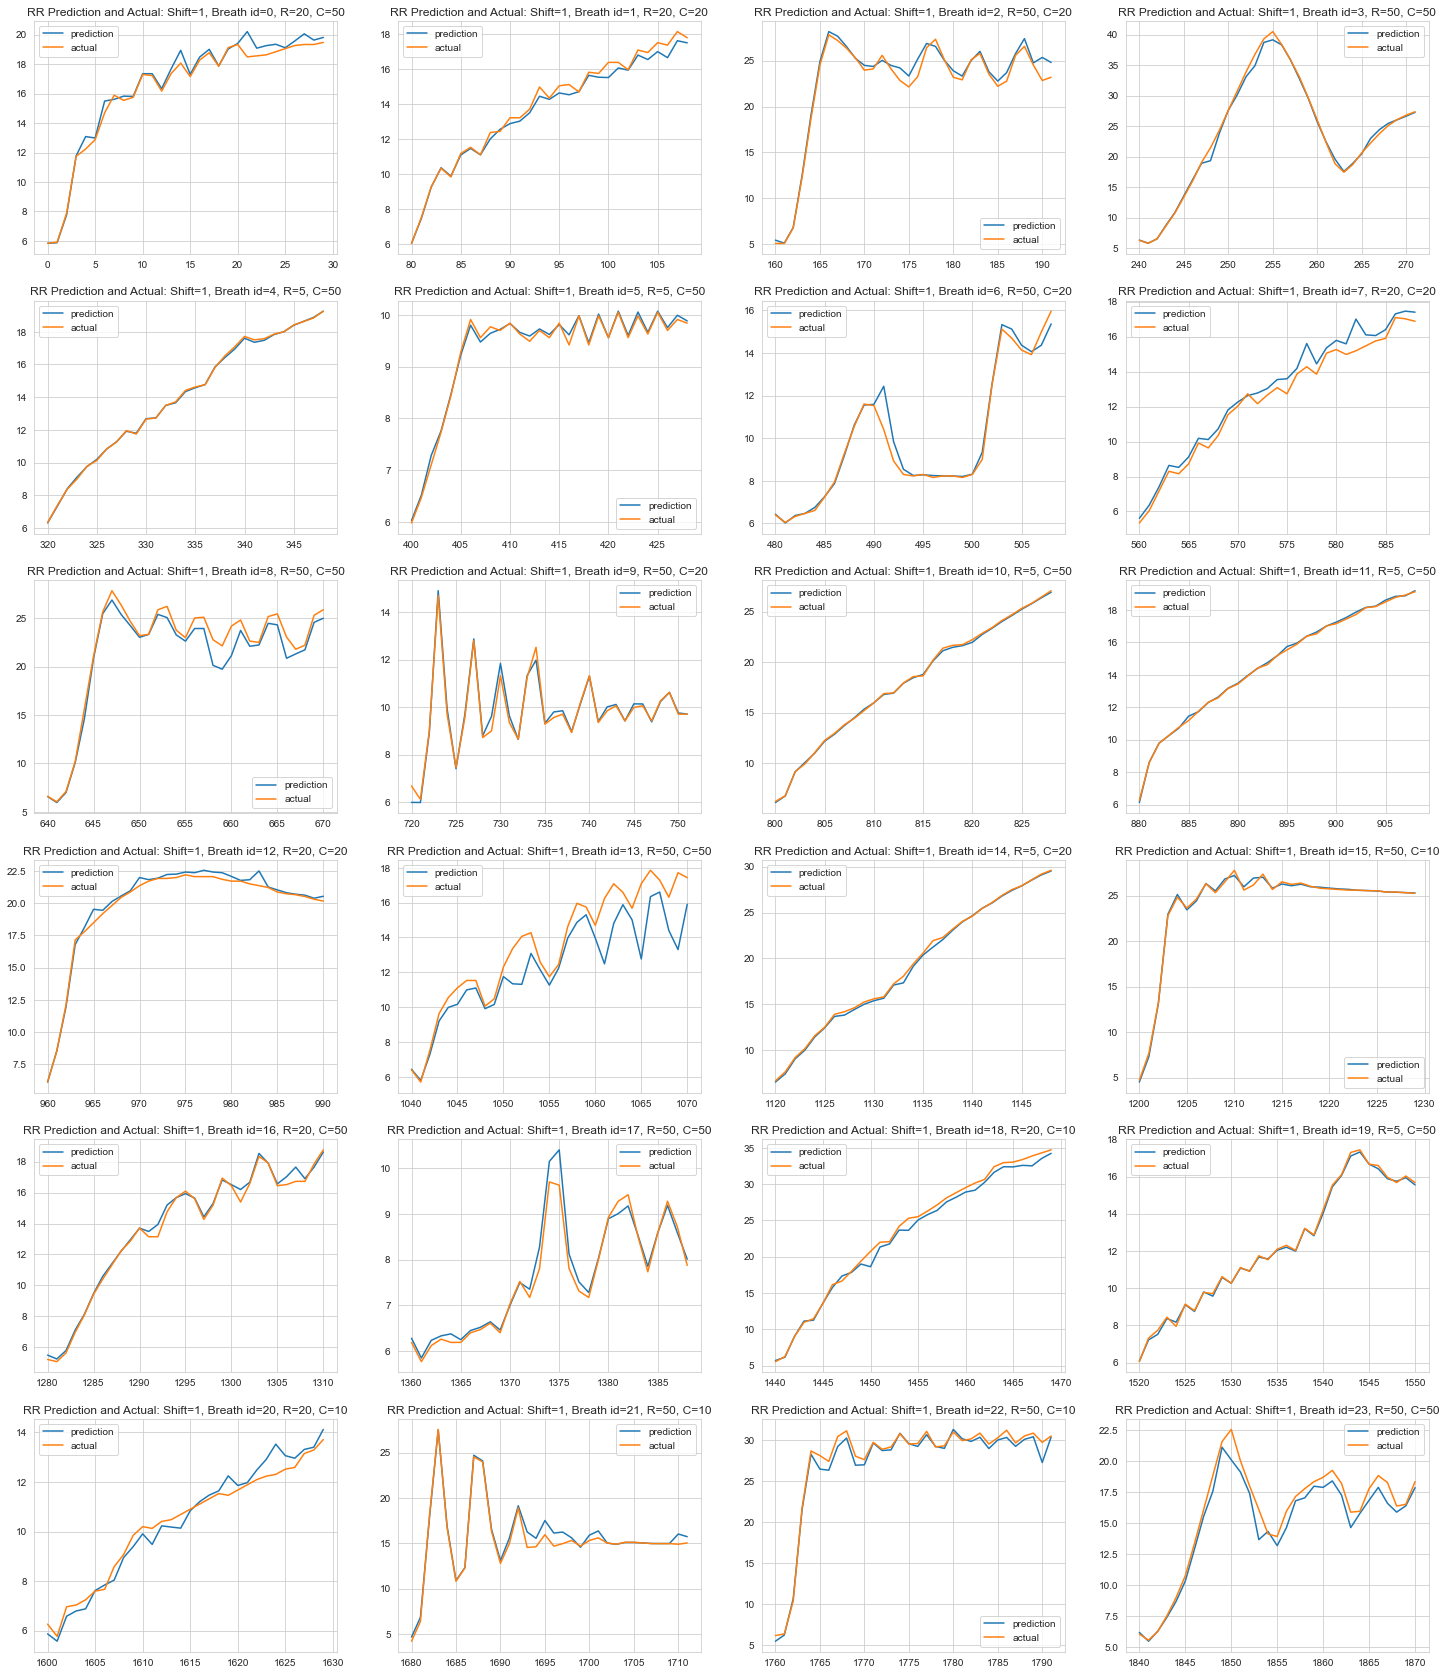

In [35]:
# make this a function
breath_idx = train_in.breath_id.unique()
fig, ax = plt.subplots(6, 4, figsize=(25,30))
ax = ax.flatten()
for i in range(24):
    b_id = get_breath(post_analysis,breath_idx[i])
    r = b_id.R.iloc[0]
    c = b_id.C.iloc[0]
    ax[i].plot(b_id.prediction,label='prediction')
    ax[i].plot(b_id.acutal,label='actual')
    ax[i].set_title(f'RR Prediction and Actual: Shift=1, Breath id={i}, R={r}, C={c}')
    ax[i].legend();
    
#plt.savefig('RndFrst_pred_actual_shift=1_tot_time.png')


ValueError: Found input variables with inconsistent numbers of samples: [6036000, 1527565]

In [40]:
l = train_in.u_in_lag.apply(np.log())

ValueError: invalid number of arguments